# Changes in loading and their flexural response in a foreland basin

This notebook was designed to play around with gflex and compare flexure for two different loading conditions as a proxy to what would happen if the flexural load changes. For instance in response to a change in exhumation in the Alps.

link to gflex repository: https://github.com/awickert/gFlex

In [128]:
import gflex
import numpy as np
from matplotlib import pyplot as pl

In [129]:
g = 9.81

n_grid_points = 500
dx = 1000

# sediment density / density of the basin infill: (kg/m3)
sediment_density = 2000.0

# effective elastic thickness of the lithosphere:
Te = 25000.0

# density of the mantle
mantle_density = 3300.0

# density of the material forming the load (ie, the additional crustal thickness)
load_density = 2500.0

## set up 1D gflex model to simulate flexure:

In [130]:
flex = gflex.F1D()

flex.Quiet = False

flex.Method = 'FD' # Solution method: * FD (finite difference)
                   #                  * SAS (superposition of analytical solutions)
                   #                  * SAS_NG (ungridded SAS)
flex.PlateSolutionType = 'vWC1994' # van Wees and Cloetingh (1994)
                                   # The other option is 'G2009': Govers et al. (2009)
flex.Solver = 'direct' # direct or iterative
flex.iterative_ConvergenceTolerance = 1e-4
# convergence = 1E-3 # convergence between iterations, if an iterative solution
                     # method is chosen

flex.g = g # acceleration due to gravity
flex.E = 65E9 # Young's Modulus
flex.nu = 0.25 # Poisson's Ratio
flex.rho_m = mantle_density # MantleDensity
flex.rho_fill = sediment_density # InfiillMaterialDensity


flex.Te = Te * np.ones((n_grid_points)) # Elastic thickness [m] -- scalar but may be an array

flex.qs = np.zeros((n_grid_points))

flex.dx = dx # grid cell size, x-oriented [m]

# Boundary conditions can be:
# (FD): 0Slope0Shear, 0Moment0Shear, 0Displacement0Slope, Mirror, or Periodic
# For SAS or SAS_NG, NoOutsideLoads is valid, and no entry defaults to this
flex.BC_W = '0Displacement0Slope' # west boundary condition
#flex.BC_E = '0Displacement0Slope' # west boundary condition
flex.BC_E = '0Moment0Shear' # east boundary condition

flex.initialize()



*********************************
*** Initializing gFlex v1.1.0 ***
*********************************

Open-source licensed under GNU GPL v3


No value entered for optional parameter "Plot"
in category "output" in configuration file.
No action related to this optional parameter will be taken.

F1D initialized


In [131]:
flex.x

## setup loads:

In [132]:
x = np.arange(n_grid_points) * dx


load_distribution = 'wedge'

qss = []

if load_distribution is 'line':
    
    # simple line loads:
    load_centre = 500e3
    # width of the line load. the left hand side is deifned by the centre location minus the width
    load_widths = [100e3, 50e3]
    
    # the height of the load
    # the stress is calculated by multiplying this with g and the 
    # load_density paramter defined previously
    load_heights = [1000.0, 2000.0]
    
    
    for load_height, load_width in zip(load_heights, load_widths):
        load = load_height * load_density * g
        x_load_min = load_centre - load_width
        x_load_max = load_centre 
        
        xmin_load = int(x_load_min / dx)
        xmax_load = int(x_load_max / dx)
        xmin_load_init = xmin_load

        qs = np.zeros((n_grid_points))
        qs[xmin_load:xmax_load] = load
        qss.append(qs)

elif load_distribution is 'wedge':
    
    # triangular shape for the load, approximation of an orogenic wedge

    # load 1: a wedge with max thickness of 25 km 
    # follows estimates of crustal thickness in the Alps by Kahle et al. 1980
    # https://www.researchgate.net/publication/313697418_Recent_dynamics_crustal_structure_and_gravity_in_the_Alps
    slope = 0.25
    load1 = (x - 400000.0) * slope * load_density * g
    load1[load1<0] = 0
    
    # load 2, a steeper internal load, but keeping the total load equal:
    slope2 = 0.8 * 0.25
    load2a = (x - 400000.0) * slope2 * load_density * g
    load2b = (x - 450000.0) * slope2 * load_density * g
    load2a[load2a<0] = 0
    load2b[load2b<0] = 0
    load2 = load2a + load2b
        
    for load in [load1, load2]:
        qs = np.zeros((n_grid_points))
        qs[:] = load
        qss.append(qs)

## Run the model for each load condition and record the deflection of the lithosphere:

In [133]:
deflections = []

for n_model_run, qs in enumerate(qss):
    
    flex.qs = np.zeros((n_grid_points))
    flex.qs = qs
    
    flex.run()
    flex.finalize()
    
    deflection = flex.w
    
    deflections.append(deflection)
    
deflection_diff = deflections[1] - deflections[0]

Finite Difference Solution Technique
F1D run
Boundary condition, West: 0Displacement0Slope <class 'str'>
Boundary condition, East: 0Moment0Shear <class 'str'>
Boundary condition, West: 0Displacement0Slope <class 'str'>
Boundary condition, East: 0Moment0Shear <class 'str'>
Time to construct coefficient (operator) array [s]: 0.00851297378540039
Time to solve [s]: 0.01166391372680664
F1D finalized

Finite Difference Solution Technique
F1D run
Boundary condition, West: 0Displacement0Slope <class 'str'>
Boundary condition, East: 0Moment0Shear <class 'str'>
Boundary condition, West: 0Displacement0Slope <class 'str'>
Boundary condition, East: 0Moment0Shear <class 'str'>
Time to construct coefficient (operator) array [s]: 0.002318143844604492
Time to solve [s]: 0.006528139114379883
F1D finalized



## Make a figure that shows the loads and the flexural response

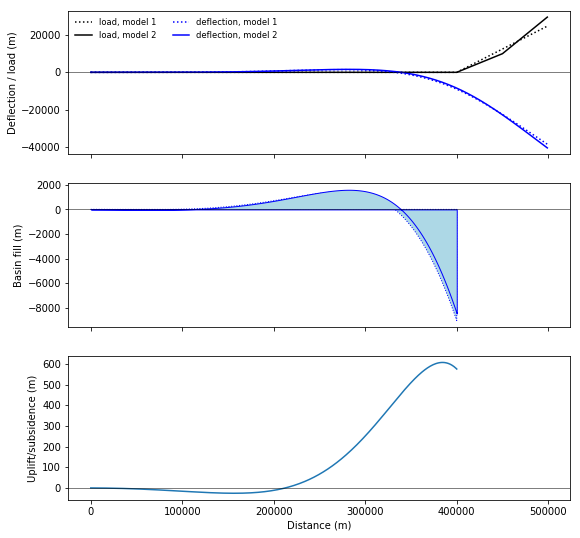

In [134]:
lss = [':', '-']

labels = ['model 1', 'model 2']

fig, axs = pl.subplots(3, 1, sharex=True, figsize=(9, 9))

ax = axs[0]
#axr = ax.twinx()

basin_edge = np.where(qss[0]>0)[0][0]

for qsi, ls, label in zip(qss, lss, labels):
    label1 = 'load, ' + label
    ax.plot(x, qsi / (load_density * g), color='black', ls=ls, label=label1)

for deflection, ls, label in zip(deflections, lss, labels):
    label2 = 'deflection, ' + label
    ax.plot(x, deflection, color='blue', ls=ls, label=label2)
    
ax.legend(loc='upper left', ncol=2, frameon=False, fontsize='small')

#axr.set_ylabel('Load (m)')
ax.set_ylabel('Deflection / load (m)')

axb = axs[1]
for deflection, ls in zip(deflections, lss):
    axb.fill_between(x[:basin_edge], deflection[:basin_edge], 
                     linestyle=ls, edgecolor='blue', facecolor='lightblue')
axb.set_ylabel('Basin fill (m)')
 
axd = axs[2]
axd.plot(x[:basin_edge], deflection_diff[:basin_edge])
axd.set_ylabel('Uplift/subsidence (m)')

axd.set_xlabel('Distance (m)')

for ax in axs:
    ax.axhline(y=0, color='black', lw=0.5)



**Figure caption**: *Flexural response of the Molasse basin to additional crustal thickness of 25 km in the Alps, assuming a finite lithosphere with 0 shear at its tip below the Alps. The figure shows the response to two different loads, and the uplift or subsidence that results from changing the loads (bottom panel)*

## Change the boundary conditions to a fully coupled (continuous) European and Adriatic plate

In [135]:
n_grid_points = 1000

In [136]:
flex = gflex.F1D()

flex.Quiet = False

flex.Method = 'FD' # Solution method: * FD (finite difference)
                   #                  * SAS (superposition of analytical solutions)
                   #                  * SAS_NG (ungridded SAS)
flex.PlateSolutionType = 'vWC1994' # van Wees and Cloetingh (1994)
                                   # The other option is 'G2009': Govers et al. (2009)
flex.Solver = 'direct' # direct or iterative
flex.iterative_ConvergenceTolerance = 1e-4
# convergence = 1E-3 # convergence between iterations, if an iterative solution
                     # method is chosen

flex.g = g # acceleration due to gravity
flex.E = 65E9 # Young's Modulus
flex.nu = 0.25 # Poisson's Ratio
flex.rho_m = 3300. # MantleDensity
flex.rho_fill = sediment_density # InfiillMaterialDensity


flex.Te = 25000. * np.ones((n_grid_points)) # Elastic thickness [m] -- scalar but may be an array

flex.qs = np.zeros((n_grid_points))

flex.dx = dx # grid cell size, x-oriented [m]

# Boundary conditions can be:
# (FD): 0Slope0Shear, 0Moment0Shear, 0Displacement0Slope, Mirror, or Periodic
# For SAS or SAS_NG, NoOutsideLoads is valid, and no entry defaults to this
flex.BC_W = '0Displacement0Slope' # west boundary condition
#flex.BC_E = '0Displacement0Slope' # west boundary condition
flex.BC_E = '0Moment0Shear' # east boundary condition

flex.initialize()



*********************************
*** Initializing gFlex v1.1.0 ***
*********************************

Open-source licensed under GNU GPL v3


No value entered for optional parameter "Plot"
in category "output" in configuration file.
No action related to this optional parameter will be taken.

F1D initialized


## Setup loads for fully coupled European and Adriatic plate

In [137]:
x = np.arange(n_grid_points) * dx

# density of the material forming the load
load_density = 2500.0

load_distribution = 'wedge'

qss = []

if load_distribution is 'line':
    
    # simple line loads:
    load_centre = 500e3
    # width of the line load. the left hand side is deifned by the centre location minus the width
    load_widths = [100e3, 50e3]
    
    # the height of the load
    # the stress is calculated by multiplying this with g and the 
    # load_density paramter defined previously
    load_heights = [1000.0, 2000.0]
    
    
    for load_height, load_width in zip(load_heights, load_widths):
        load = load_height * load_density * g
        x_load_min = load_centre - load_width
        x_load_max = load_centre + load_width
        
        xmin_load = int(x_load_min / dx)
        xmax_load = int(x_load_max / dx)
        
        if xmax_load > n_grid_points:
            xmax_load = n_grid_points
            
        xmin_load_init = xmin_load

        qs = np.zeros((n_grid_points))
        qs[xmin_load:xmax_load] = load
        qss.append(qs)

elif load_distribution is 'wedge':
    
    # triangular shape for the load, approximation of an orogenic wedge

    # load 1: a wedge with max thickness of 25 km (Kahle et al. 1980)
    # https://www.researchgate.net/publication/313697418_Recent_dynamics_crustal_structure_and_gravity_in_the_Alps
    slope = 0.25
    load1a = (x - 400000.0) * slope * load_density * g
    load1 = np.zeros_like(x)
    xmid = int(n_grid_points / 2)
    load1[:xmid] = load1a[:xmid]
    load1[xmid:] = load1a[:xmid][::-1]
    
    load1[load1<0] = 0
    
    # load 2, a steeper internal load, but keeping the total load equal:
    slope2 = 0.8 * 0.25
    load2a = (x - 400000.0) * slope2 * load_density * g
    load2b = (x - 450000.0) * slope2 * load_density * g
    load2a[load2a<0] = 0
    load2b[load2b<0] = 0
    load2c = load2a + load2b

    load2 = np.zeros_like(x)
    load2[:xmid] = load2c[:xmid]
    load2[xmid:] = load2c[:xmid][::-1]

    for load in [load1, load2]:
        qs = np.zeros((n_grid_points))
        qs[:] = load
        qss.append(qs)

## Run the model with the new bnd conditions

In [138]:
deflections = []

for n_model_run, qs in enumerate(qss):
    
    flex.qs = np.zeros((n_grid_points))
    flex.qs = qs
    
    flex.run()
    flex.finalize()
    
    deflection = flex.w
    
    deflections.append(deflection)
    
deflection_diff = deflections[1] - deflections[0]

Finite Difference Solution Technique
F1D run
Boundary condition, West: 0Displacement0Slope <class 'str'>
Boundary condition, East: 0Moment0Shear <class 'str'>
Boundary condition, West: 0Displacement0Slope <class 'str'>
Boundary condition, East: 0Moment0Shear <class 'str'>
Time to construct coefficient (operator) array [s]: 0.0077800750732421875
Time to solve [s]: 0.01071619987487793
F1D finalized

Finite Difference Solution Technique
F1D run
Boundary condition, West: 0Displacement0Slope <class 'str'>
Boundary condition, East: 0Moment0Shear <class 'str'>
Boundary condition, West: 0Displacement0Slope <class 'str'>
Boundary condition, East: 0Moment0Shear <class 'str'>
Time to construct coefficient (operator) array [s]: 0.0019888877868652344
Time to solve [s]: 0.004884004592895508
F1D finalized



## Make a figure that shows the loads and the flexural response for the new bnd condition

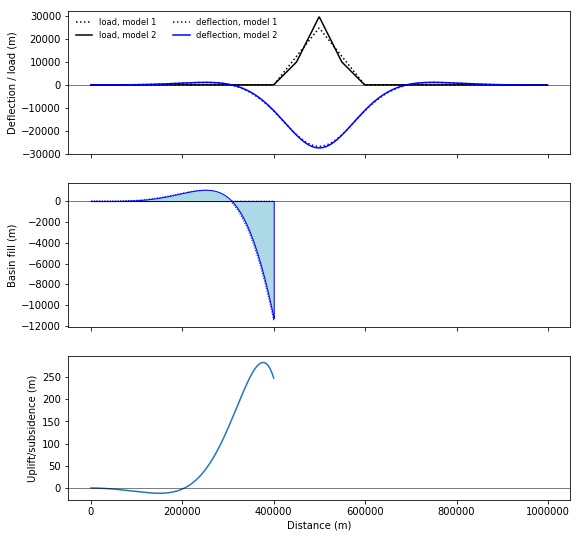

In [139]:
lss = [':', '-']

labels = ['model 1', 'model 2']

fig, axs = pl.subplots(3, 1, sharex=True, figsize=(9, 9))

ax = axs[0]
#axr = ax.twinx()

basin_edge = np.where(qss[0]>0)[0][0]

for qsi, ls, label in zip(qss, lss, labels):
    label1 = 'load, ' + label
    ax.plot(x, qsi / (load_density * g), color='black', ls=ls, label=label1)

for deflection, ls, label in zip(deflections, lss, labels):
    label2 = 'deflection, ' + label
    ax.plot(x, deflection, color='blue', ls=ls, label=label2)
    
ax.legend(loc='upper left', ncol=2, frameon=False, fontsize='small')

#axr.set_ylabel('Load (m)')
ax.set_ylabel('Deflection / load (m)')

axb = axs[1]
for deflection, ls in zip(deflections, lss):
    axb.fill_between(x[:basin_edge], deflection[:basin_edge], 
                     linestyle=ls, edgecolor='blue', facecolor='lightblue')
axb.set_ylabel('Basin fill (m)')
 
axd = axs[2]
axd.plot(x[:basin_edge], deflection_diff[:basin_edge])
axd.set_ylabel('Uplift/subsidence (m)')

axd.set_xlabel('Distance (m)')

for ax in axs:
    ax.axhline(y=0, color='black', lw=0.5)

**Figure caption**: *Flexural response of the Molasse basin to additional crustal thickness of 25 km in the Alps, assuming a continuous unbroken lithosphere below the Alps. The figure shows the response to two different loads, and the uplift or subsidence that results from changing the loads (bottom panel)*